#### [ Pytorch 기반 회귀 모델 구현 ]
- Layer => Full-Connected Layer, Linear 
- 손실함수 : MSELoss, MAELoss ... 

- [1] 데이터 준비 <hr>

In [345]:
import pandas as pd

In [346]:
file = pd.read_csv('../../data/BostonHousing.csv')
file.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [347]:
dataDF = file.loc[:, file.columns[:-1]]
dataDF.shape

(506, 13)

In [348]:
labelSR = file[file.columns[-1]]
labelSR.shape

(506,)

- [2] 사용자 데이터셋 클래스 정의 <hr>

In [349]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [350]:
### 클래스 정의

# 이거는 정하기 나름이다. 클래스 안에서 전처리를 해도 되고 밖에서 해도 되고~ 
class BostonDS(Dataset):
    # 데이터 전처리 => 정규화 , 텐서화
    def __init__(self, feature, target):
        super().__init__()
        self.feature = torch.FloatTensor(feature)
        self.target = torch.FloatTensor(target)
        self.length = self.feature.shape[0] 
        self.norm_feature = self.normalization()
        self.norm_target = self.normalization()

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.feature[index], self.target[index]
    
    # 데이터 정규화 기능 함수
    def normalization(self):
        self.feature.max(dim=1)

In [351]:
labelDF = labelSR.to_frame()

In [352]:
data_array = np.array(dataDF)
label_array = np.array(labelSR)

In [353]:
boston_DS = BostonDS(data_array, label_array)

In [354]:
len(boston_DS)

506

In [355]:
train_size = int(len(boston_DS)*0.8)
val_size = int(len(boston_DS)*0.1)
test_size = int(len(boston_DS) - train_size - val_size)
print(train_size, val_size, test_size)

404 50 52


In [356]:
train_dataset, val_dataset, test_dataset = random_split(boston_DS, [train_size, val_size, test_size])

In [357]:
BATCH = 26
train_DL = DataLoader(train_dataset, batch_size = BATCH, shuffle = True)
val_DL = DataLoader(val_dataset, batch_size= BATCH, shuffle = True)
test_DL = DataLoader(test_dataset, batch_size = BATCH, shuffle = True)

- [3] 모델 생성

In [358]:
class my_model(nn.Module):
    def __init__(self, in_, out_):
        super().__init__()
        self.layer1 = nn.Linear(in_, 20)
        self.layer2 = nn.Linear(20, 15)
        self.layer4 = nn.Linear(15, out_)
        self.relu = nn.ReLU()
    
    def forward(self, k):
        k = self.layer1(k)
        k = self.relu(k)
        k = self.layer2(k)
        k = self.relu(k)
        k = self.layer4(k)
        total_k = self.relu(k)
        return total_k

##### super().__init__()을 하는것을 잊지말자.

In [359]:
dataDF.shape[1]

13

- [4] 학습을 위한 변수 선언

In [360]:
import torch.optim as optim
IN, OUT = dataDF.shape[1], 1
EPOCH = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'   # 디바이스 설정
model = my_model(IN, OUT).to(device)  # 모델 인스턴스 
loss_fn = nn.MSELoss().to(device)  # 손실함수 
optimizer = optim.Adam(model.parameters())  # 최적화를 위한 옵티마이저 인스턴스 생성

- [5] 함수 설정 (학습, 평가)

In [361]:
# !pip install torcheval
from torcheval.metrics.functional import r2_score

In [362]:
def training(dataloader):
    model.train()
    
    loss_list = []
    f1_list = []
    # 학습 진행 (배치크기 만큼의 데이터 꺼내긔)
    for (feature, label) in dataloader:
        feature, label = feature.to(device), label.to(device)
        
        pred = model(feature)
        pred = pred.squeeze(dim=1)
        # print(f"label.shape : {label.shape}    pred.shape : {pred.shape}")
        # 손실계산
        loss = loss_fn(pred, label)
        
        # 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 성과
        f1 = r2_score(pred, label)
        
        loss_list.append(loss.item())
        f1_list.append(f1.item())
        
    total_loss = round(sum(loss_list) / len(loss_list),3)
    total_f1 = round(sum(f1_list) / len(f1_list),3)
    # print(f"loss => {total_loss}   f1 score : {total_f1}")
    return total_loss, total_f1

training(train_DL)

(375.152, -6.284)

In [363]:
def testing(dataloader):
    model.eval()
    loss_list = []
    f1_list = []
    # 학습 진행 (배치크기 만큼의 데이터 꺼내긔)
    for (feature, label) in dataloader:
        feature, label = feature.to(device), label.to(device)
        pred = model(feature)
        pred = pred.squeeze(dim=1)
        # 손실계산
        loss = loss_fn(pred, label)   
        # 성과
        f1 = r2_score(pred, label)
        
        loss_list.append(loss.item())
        f1_list.append(f1.item())
        
    total_loss = round(sum(loss_list) / len(loss_list),3)
    total_f1 = round(sum(f1_list) / len(f1_list),3)
    # print(f"loss => {total_loss}   f1 score : {total_f1}")
    return total_loss, total_f1

# testing(test_DL)

- [6] 학습 진행

In [364]:
train_list = [[], []]
test_list = [[], []]
for epo in range(EPOCH):
    tr_loss, tr_f1 = training(train_DL)
    train_list[0].append(tr_loss)
    train_list[1].append(tr_f1)
    ts_loss, ts_f1 = testing(val_DL)
    test_list[0].append(ts_loss)
    test_list[1].append(ts_f1)
    print('.', end = ' ')

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [365]:
epoch_list = [k for k in range(EPOCH)]

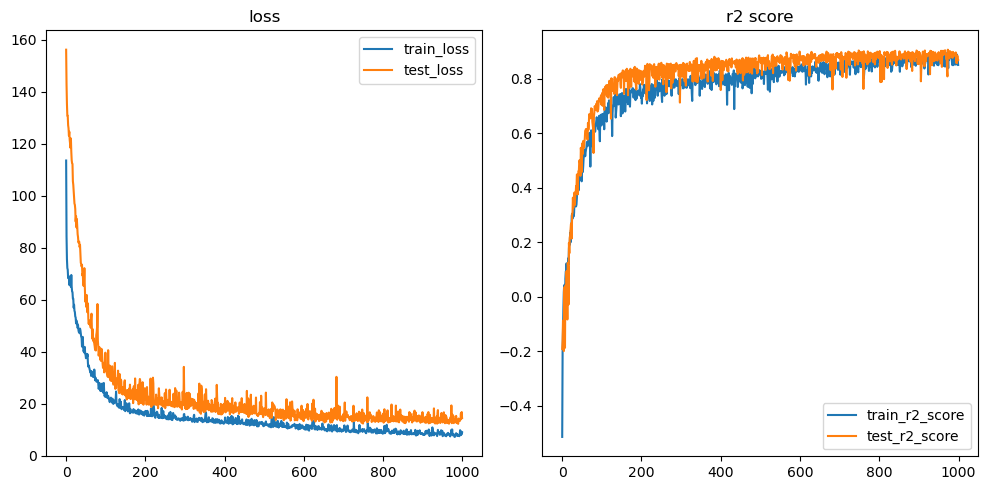

In [366]:
# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(epoch_list, train_list[0], label = 'train_loss')
plt.plot(epoch_list, test_list[0], label = 'test_loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list, train_list[1], label = 'train_r2_score')
plt.plot(epoch_list, test_list[1], label = 'test_r2_score')
plt.title('r2 score')
plt.legend()

plt.tight_layout()
plt.show()

- (7) 예측

In [367]:
def predicting(dataloader):
    model.eval()
    pred_list = []
    count = 1
    # 학습 진행 (배치크기 만큼의 데이터 꺼내긔)
    for (feature, label) in dataloader:
        feature, label = feature.to(device), label.to(device)
        pred = model(feature)
        pred = pred.squeeze(dim=1)
        pred_list.append(pred)
        print(f"============={count}=============")
        print(f"label\n{label}")
        print(f"pred\n{pred}")
        count +=1
predicting(test_DL)

=============1=============
label
tensor([24.7000, 15.0000, 19.8000, 16.1000, 15.2000, 25.3000, 27.0000, 22.8000,
        21.4000, 22.4000, 16.6000, 23.1000, 34.9000, 23.5000, 11.8000, 33.4000,
        50.0000, 21.9000, 19.4000, 18.5000, 18.5000, 20.6000, 50.0000, 50.0000,
        45.4000, 23.7000])
pred
tensor([24.2031, 30.2728, 22.0419, 18.7960, 18.9701, 25.2102, 37.7283, 26.4720,
        24.4573, 21.5327, 19.5106, 25.1498, 36.9017, 33.8049, 13.8112, 40.8003,
        28.0766, 20.6700, 22.8008, 18.5019, 24.1741, 21.2049, 58.3163, 46.0473,
        45.7067, 29.4410], grad_fn=<SqueezeBackward1>)
=============2=============
label
tensor([14.9000, 29.9000, 33.8000, 13.0000, 20.3000, 27.5000, 19.3000, 32.2000,
        13.9000, 26.4000, 15.2000, 17.1000, 24.2000, 23.8000, 14.4000, 27.9000,
        19.6000, 18.9000, 22.5000, 13.1000, 10.5000, 11.8000, 18.0000, 28.7000,
        46.0000, 20.6000])
pred
tensor([18.2080, 30.8542, 33.0994, 16.9767, 24.4298, 28.0076, 19.0758, 30.6018,
        14.25